In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import precision_score, recall_score,f1_score,roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# lecture des données

In [2]:
df = pd.read_csv('email.csv')
df.head(5)

,text,spam
0,Subject: christmas tree farm pictures\r\r\n,1
1,"Subject: vastar resources , inc .\r\r\ngary , ...",1
2,Subject: calpine daily gas nomination\r\r\n- c...,1
3,Subject: re : issue\r\r\nfyi - see note below ...,1
4,Subject: meter 7268 nov allocation\r\r\nfyi .\...,1


In [3]:
df['spam'].value_counts()

1    8033
0    1967
Name: spam, dtype: int64

# pretraitement et division de la dataset

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

import re
import string
import nltk

cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

df["Text_Clean"] = df["text"].apply(cleanup)

train, test = train_test_split(df, test_size=0.3)
print("%d items in training data, %d in test data" % (len(train), len(test)))
df.shape

7000 items in training data, 3000 in test data


(10000, 3)

# extraction feautures avec TFIDF

In [5]:
from wordcloud import WordCloud, STOPWORDS

# To cleanup stop words, add stop_words = STOPWORDS
# But it seems to function better without it
count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = count_vect.fit_transform(train["Text_Clean"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = count_vect.transform(test["Text_Clean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["spam"]
y_test = test["spam"]

prediction = dict()

# naive-bayes(Multinomial)

In [6]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)
import seaborn as sb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("_"*101)
print(" Bayes-naive MULTINOMIAL Rapport: \n")
print(classification_report(y_test, prediction['Multinomial']))

accuracy_mlt = accuracy_score(y_test, prediction['Multinomial'])
prediction['Multinomial']= accuracy_mlt * 100

print("_"*101)

_____________________________________________________________________________________________________
 Bayes-naive MULTINOMIAL Rapport: 

              precision    recall  f1-score   support

           0       1.00      0.17      0.28       611
           1       0.82      1.00      0.90      2389

    accuracy                           0.83      3000
   macro avg       0.91      0.58      0.59      3000
weighted avg       0.86      0.83      0.78      3000

_____________________________________________________________________________________________________


# naive-bayes(bernouilli)

In [7]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

import seaborn as sb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("_"*101)
print(" Bayes-naive Bernouli Rapport: \n")
print(classification_report(y_test, prediction['Bernoulli']))

accuracy_Ber= accuracy_score(y_test, prediction['Bernoulli'])
prediction['Bernouilli']= accuracy_Ber * 100
print("_"*101)

_____________________________________________________________________________________________________
 Bayes-naive Bernouli Rapport: 

              precision    recall  f1-score   support

           0       0.92      0.13      0.22       611
           1       0.82      1.00      0.90      2389

    accuracy                           0.82      3000
   macro avg       0.87      0.56      0.56      3000
weighted avg       0.84      0.82      0.76      3000

_____________________________________________________________________________________________________


# KNN

In [8]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_tfidf, y_train)
prediction['knn'] = knn.predict(X_test_tfidf)

print("_"*101)
print(" KNN Rapport: \n")
print(classification_report(y_test, prediction['knn']))
accuracy_knn = accuracy_score(y_test, prediction['knn'])
prediction['knn']= accuracy_knn * 100

print("_"*101)

_____________________________________________________________________________________________________
 KNN Rapport: 

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       611
           1       0.98      0.97      0.98      2389

    accuracy                           0.96      3000
   macro avg       0.94      0.95      0.94      3000
weighted avg       0.96      0.96      0.96      3000

_____________________________________________________________________________________________________


# arbre de decision

In [12]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train_tfidf, y_train)
prediction['DTree'] = dt.predict(X_test_tfidf)

print("_"*101)
print(" dt Rapport: \n")
print(classification_report(y_test, prediction['DTree']))
accuracy_Dtree = accuracy_score(y_test, prediction['DTree'])
prediction['DTree']= accuracy_Dtree * 100
print("_"*101)



_____________________________________________________________________________________________________
 dt Rapport: 

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       611
           1       0.94      0.97      0.95      2389

    accuracy                           0.92      3000
   macro avg       0.90      0.86      0.88      3000
weighted avg       0.92      0.92      0.92      3000

_____________________________________________________________________________________________________


# SVM

In [18]:
import scikitplot as skplt
SVM = svm.SVC()
SVM.fit(X_train_tfidf, y_train)
predicted_values_SVM = SVM.predict(X_test_tfidf)
#print(predicted_values_SVM)
accuracy_SVM = accuracy_score(y_test, predicted_values_SVM)
prediction['Support Vector Machine (SVM)'] = accuracy_SVM * 100

print("_"*101)
print(" support vector Rapport: \n")
print(classification_report(y_test, predicted_values_SVM))
accuracy_Dtree = accuracy_score(y_test, predicted_values_SVM)
predicted_values_SVM = accuracy_Dtree * 100
print("_"*101)


_____________________________________________________________________________________________________
 support vector Rapport: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       611
           1       0.80      1.00      0.89      2389

    accuracy                           0.80      3000
   macro avg       0.40      0.50      0.44      3000
weighted avg       0.63      0.80      0.71      3000

_____________________________________________________________________________________________________


C:\Users\Jojo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Jojo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Jojo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# regression Logistic

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)
import seaborn as sb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("_"*101)
print(" regression logistci: \n")
print(classification_report(y_test, prediction['Logistic']))
accuracy_Log = accuracy_score(y_test, prediction['Logistic'])
prediction['Logistic']= accuracy_Log * 100
print("_"*101)


C:\Users\Jojo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


_____________________________________________________________________________________________________
 regression logistci: 

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       611
           1       0.99      1.00      0.99      2389

    accuracy                           0.99      3000
   macro avg       0.99      0.97      0.98      3000
weighted avg       0.99      0.99      0.99      3000

_____________________________________________________________________________________________________


# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 100, oob_score = True)
# n_estimators - количество деревьев в лесе
# oob_score - использовать ли образцы вне примеров для оценки точности обобщения
RF.fit(X_train_tfidf, y_train)
predicted_values_RF = RF.predict(X_test_tfidf)
accuracy_RF = accuracy_score(y_test, predicted_values_RF)
prediction['Random Forest'] = accuracy_RF * 100


print("_"*101)
print(" random forest: \n")
print(classification_report(y_test, predicted_values_RF))
accuracy_Log = accuracy_score(y_test, predicted_values_RF)
predicted_values_RF= accuracy_Log * 100
print("_"*101)

_____________________________________________________________________________________________________
 random forest: 

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       611
           1       0.94      1.00      0.97      2389

    accuracy                           0.95      3000
   macro avg       0.96      0.87      0.91      3000
weighted avg       0.95      0.95      0.94      3000

_____________________________________________________________________________________________________


,Algorithms,Percentage
0,Multinomial,83
1,Bernoulli,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ..."
2,Bernouilli,82
3,knn,96.1333
4,DTree,92.4667
5,Support Vector Machine (SVM),79.6333
6,Logistic,98.7333
7,Random Forest,94.6


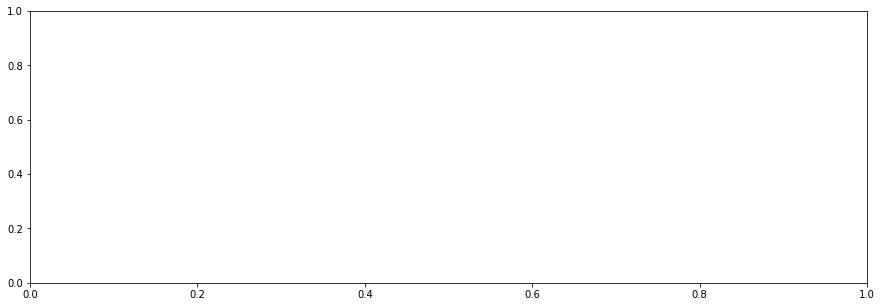

In [20]:
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(ncols = 1, sharey = True,figsize = (15,5))
df = pd.DataFrame(list(prediction.items()),columns = ['Algorithms','Percentage'])
display(df)
